In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.distributions.empirical_distribution import ECDF

#import testing
import sys
sys.path.append("../")
import vuong_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
num_bidders = 10
num_bidders2 = 3
mu = 60
sigma = 60

def gen_data(values=stats.logistic(loc=mu, scale=sigma)):
    nobs = 1000
    
    #parameters
    min_bids =num_bidders
    max_bids =num_bidders
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids,bidders,nobs

values_distr =stats.logistic(loc=mu, scale=sigma)
bids,i,nobs = gen_data(values_distr)
print(bids.shape)
print(bids[i == num_bidders].mean())

(1000,)
161.28869733174753


In [93]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.logistic, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)

np.random.seed()
yn,xn,nobs = gen_data(stats.logistic(loc=mu, scale=sigma))
model = Auction(yn,xn)
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -5321.7
Model:                        Auction   AIC:                         1.065e+04
Method:            Maximum Likelihood   BIC:                         1.065e+04
Date:                Mon, 21 Dec 2020                                         
Time:                        19:43:29                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7412      2.385     25.044      0.000      55.066      64.417
par0          58.5184      1.389     42.123      0.000      55.796      61.241
==============================================================================
"""

In [94]:
def compute_llr(yn,xn):
    
    #fit normal values
    model1 = Auction(yn,xn)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,xn*num_bidders2/num_bidders)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(21.12907318501675, 0.1954874878460562)


0
1


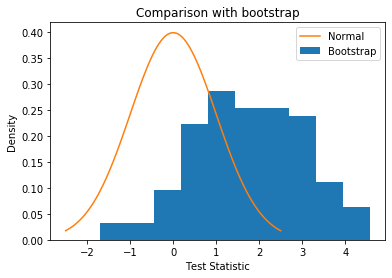

In [95]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare_bidders')
plt.show()

In [96]:
reg,boot,llr, omega = vuong_tests.monte_carlo(20,gen_data,compute_llr)
print("reg: %s, boot: %s, llr:%s, omega:%s"%(reg,boot,llr, omega))

/home/erichschulman/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4221: RuntimeWarning: overflow encountered in exp
  return -x - 2. * sc.log1p(np.exp(-x))
/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


reg: [0.15 0.85 0.  ], boot: [0.15 0.85 0.  ], llr:17.80538802605206, omega:0.17138272427404794


In [97]:
def setup_shi(yn,xn):
    model1 = Auction(yn,xn)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,xn*num_bidders2/num_bidders)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,2, grad2,hess2,2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [90]:
shi_result = vuong_tests.monte_carlo_shi(10,setup_shi,gen_data)
print(shi_result)

/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


[0.1 0.9 0. ]


In [91]:
#normal distribution, 5, 20 bidders
#reg: [0.82 0.18 0.  ], boot: [0.78 0.22 0.  ], llr:2.602891682004338, omega:0.07058141556876986
#shi: [0.97 0.03 0.  ]

#logistic distribution, num_bidders2 = 3, num_bidders = 6, mu = 20, sigma = 5
#reg: [0.85 0.15 0.  ], boot: [0.8 0.2 0. ], llr:2.0640882842566497, omega:0.07172781203070461

#logistic distribution, num_bidders2 = 6, num_bidders = 2, mu = 20, sigma = 5
#reg: [0.85 0.15 0.  ], boot: [0.9 0.1 0. ], llr:1.699842999683483, omega:0.07413523308440399'
#[0.78 0.22 0. ], boot: [0.78 0.22 0. ]
#[0.99 0.01 0.  ]

#num_bidders2 = 3, num_bidders = 4, mu = 20, sigma = 10
#reg: [0.6 0.4 0. ], boot: [0.7 0.3 0. ], llr:1.5855838892164684, omega:0.03291415905392439
#reg: [0.56 0.44 0.  ], boot: [0.5 0.5 0. ], llr:1.9897437189929996, omega:0.03341120424668039

#num_bidders2 = 4, num_bidders = 3, mu = 20, sigma = 10
#reg: [0.94 0.06 0.  ], boot: [0.91 0.08 0.01], llr:0.5690036148998024, omega:0.034390985434368665
#[1. 0. 0.]

#num_bidders2 = 4, num_bidders = 3, mu = 30, sigma = 10 
#reg: [1.00 0.00 0.  ], boot: [0.8 0.2 0.0], 

######## 12/18/20###########

#num_bidders = 4 num_bidders2 = 3 mu = 15 sigma = 10, logistic
#reg: [0.7 0.3 0. ], boot: [0.75 0.25 0.  ], llr:3.2696434027566967, omega:0.07019086239096824
#reg: [0.67 0.33 0.  ], boot: [0.69 0.31 0.  ], llr:2.976976241056418, omega:0.06947260639123216

#num_bidders = 4 num_bidders2 = 3 mu = 12 sigma = 10, logistic
#reg: [0.67 0.33 0.  ], boot: [0.69 0.31 0.  ], llr:3.071048369555979, omega:0.06914281774833132

#num_bidders = 4 num_bidders2 = 3 mu = 8 sigma = 10, logistic
#reg: [0.78 0.22 0.  ], boot: [0.83 0.17 0.  ], llr:2.5349933034949164, omega:0.07031971713889833

#num_bidders = 4 num_bidders2 = 3 mu = 3 sigma = 10, logistic
#reg: [0.76 0.24 0.  ], boot: [0.79 0.21 0.  ], llr:2.4000424161817957, omega:0.07144266907312949, [0.88 0.12 0.  ]

#num_bidders = 4 num_bidders2 = 3 mu = 20 sigma = 5, logistic
#reg: [0.84 0.16 0.  ], boot: [0.85 0.15 0.  ], llr:2.4119, omega:0.070727

#num_bidders = 4 num_bidders2 = 3 mu = 20 sigma = 1, logistic
#reg: [0.82 0.18 0.  ], boot: [0.84 0.16 0.  ], llr:2.4119, omega:0.070727

#num_bidders = 4 num_bidders2 = 3 mu = 30 sigma = 1, logistic
#reg: [0.72 0.28 0.  ], boot: [0.80 0.19 0.1  ], llr:2.8092, omega:0.070771

############## 12/18/20 pt ii ############################

#num_bidders = 10 num_bidders2 = 5 mu = 1 sigma = 20, logistic
#reg: [0.7 0.3 0. ], boot: [0.8 0.2 0. ], llr:3.8579200583681086, omega:0.07836696756409663
#reg: [0.68 0.02 0. ], boot: [0.71 0.19 0. ]

#num_bidders = 10 num_bidders2 = 5 mu = 1 sigma = 25, logistic
#reg: [0.65 0.35 0.  ], boot: [0.75 0.25 0.  ], llr:3.7606742186738757, omega:0.0780112806949667


#num_bidders = 10 num_bidders2 = 5 mu = 1 sigma = 30, logistic
#reg: [0.45 0.55 0.  ], boot: [0.55 0.45 0.  ], llr:4.522611922554143, omega:0.0763853682184193
#reg: [0.67 0.33 0.0], boot: [0.74 0.26 0.  ], [0.86 0.14] llr:3.47084, omega:0.078228 <---- use this one

#num_bidders = 10 num_bidders2 = 5 mu = 20 sigma = 30, logistic
#reg: [0.9 0.1 0.  ], boot: [0.9 0.1 0.  ],

#num_bidders = 10 num_bidders2 = 5 mu = 30 sigma = 30, logistic
#reg: [0.7 0.3 0.  ], boot: [0.7 0.3 0. ], llr:3.26, omega:0.0775


#num_bidders = 10 num_bidders2 = 5 mu = 60 sigma = 30, logistic <--- and this one?
#reg: [0.6 0.4 0.  ], boot: [0.6 0.4 0. ]

#num_bidders = 10 num_bidders2 = 5 mu = 120 sigma = 30, logistic
#reg: [0.7 0.3 0.  ], boot: [0.9 0.1 0. ]

#num_bidders = 10 num_bidders2 = 5 mu = 150 sigma = 30, logistic
#reg: [0.7 0.3 0.  ], boot: [0.7 0.3 0. ]

############## 12/21/20 ############################
#num_bidders = 10 num_bidders2 = 3 mu = 1 sigma = 3, logistic
#reg: [0.15 0.85 0.  ], boot: [0.15 0.85 0.  ], llr:18.285808550743308, omega:0.17603848398407118

#num_bidders = 10 num_bidders2 = 3 mu = 1 sigma = 60, logistic
#reg: [0.15 0.85 0.  ], boot: [0.4 0.6 0. ], llr:19.274817437516322, omega:0.17779566605304323

#num_bidders = 10 num_bidders2 = 3 mu = 10 sigma = 60, logistic
#reg: [0.05 0.95 0.  ], boot: [0.1 0.9 0. ], llr:18.16, omega:0.17

#num_bidders = 10 num_bidders2 = 3 mu = 60 sigma = 60, logistic
#reg: [0.15 0.85 0.  ], boot: [0.15 0.85 0.  ], llr:17.80538802605206, omega:0.17138272427404794

#num_bidders = 10 num_bidders2 = 2 mu = 1 sigma = 3, logistic
#reg: [0.0 1.0 0.  ], boot:  [0.0 1.0 0.  ], llr:57.26, omega:0.294 

#num_bidders = 10 num_bidders2 = 2 mu = 1 sigma = .5, logistic
#reg: [0. 1. 0.], boot: [0.05 0.95 0.  ], llr:21.278397941395117, omega:0.16686885694134274

#num_bidders = 10 num_bidders2 = 4 mu = 1 sigma = 1, logistic
#reg: [0.5 0.5 0.  ], boot:  [0.65 0.35 0.  ], llr:7.64, omega:0.12 

#num_bidders = 10 num_bidders2 = 4 mu = 1 sigma = 3, logistic
#reg: [0.4 0.6 0.  ], boot:  [0.45 0.55 0.  ], llr:7.49, omega:0.114 

#num_bidders = 10 num_bidders2 = 4 mu = 1 sigma = 6, logistic
#reg: [0.5 0.5 0. ], boot: [0.6 0.4 0. ], llr:6.763415206032301, omega:0.11441252699510122

#num_bidders = 10 num_bidders2 = 4 mu = 1 sigma = 10, logistic
#reg: [0.45 0.55 0.  ], boot:  [0.45 0.55 0.  ]

#num_bidders = 10 num_bidders2 = 4 mu = 1 sigma = 50, logistic
#reg: [0.3 0.7 0. ], boot: [0.35 0.65 0.  ], llr:9.468803286095044, omega:0.11349409948931999